<a href="https://colab.research.google.com/github/RishiLal/CV-FirstHtmlTemplate/blob/main/MLB_Bonus_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

      RegionName  2014-01  2014-02  2014-03  2014-04  2014-05  2014-06  \
0          Miami   2200.0   2200.0   2200.0   2200.0   2225.0   2200.0   
1        Hialeah      NaN      NaN      NaN      NaN      NaN      NaN   
2  Miami Gardens   1525.0   1500.0   1500.0   1500.0   1500.0   1500.0   
3    Miami Beach   2400.0   2400.0   2400.0   2395.0   2400.0   2390.0   
4      Homestead   1300.0   1300.0   1300.0   1300.0   1312.5   1325.0   

   2014-07  2014-08  2014-09  ...  2019-03  2019-04  2019-05  2019-06  \
0   2300.0   2217.5   2200.0  ...   2450.0   2405.0   2400.0   2400.0   
1      NaN      NaN      NaN  ...   1975.0   2000.0   2000.0   1975.0   
2   1550.0   1600.0   1600.0  ...   1750.0   1800.0   1825.0   1849.5   
3   2400.0   2400.0   2300.0  ...   2400.0   2400.0   2400.0   2362.5   
4   1350.0   1350.0   1350.0  ...   1600.0   1600.0   1650.0   1650.0   

   2019-07  2019-08  2019-09  2019-10  2019-11  2019-12  
0   2400.0   2400.0   2400.0   2400.0   2400.0   2400.0  


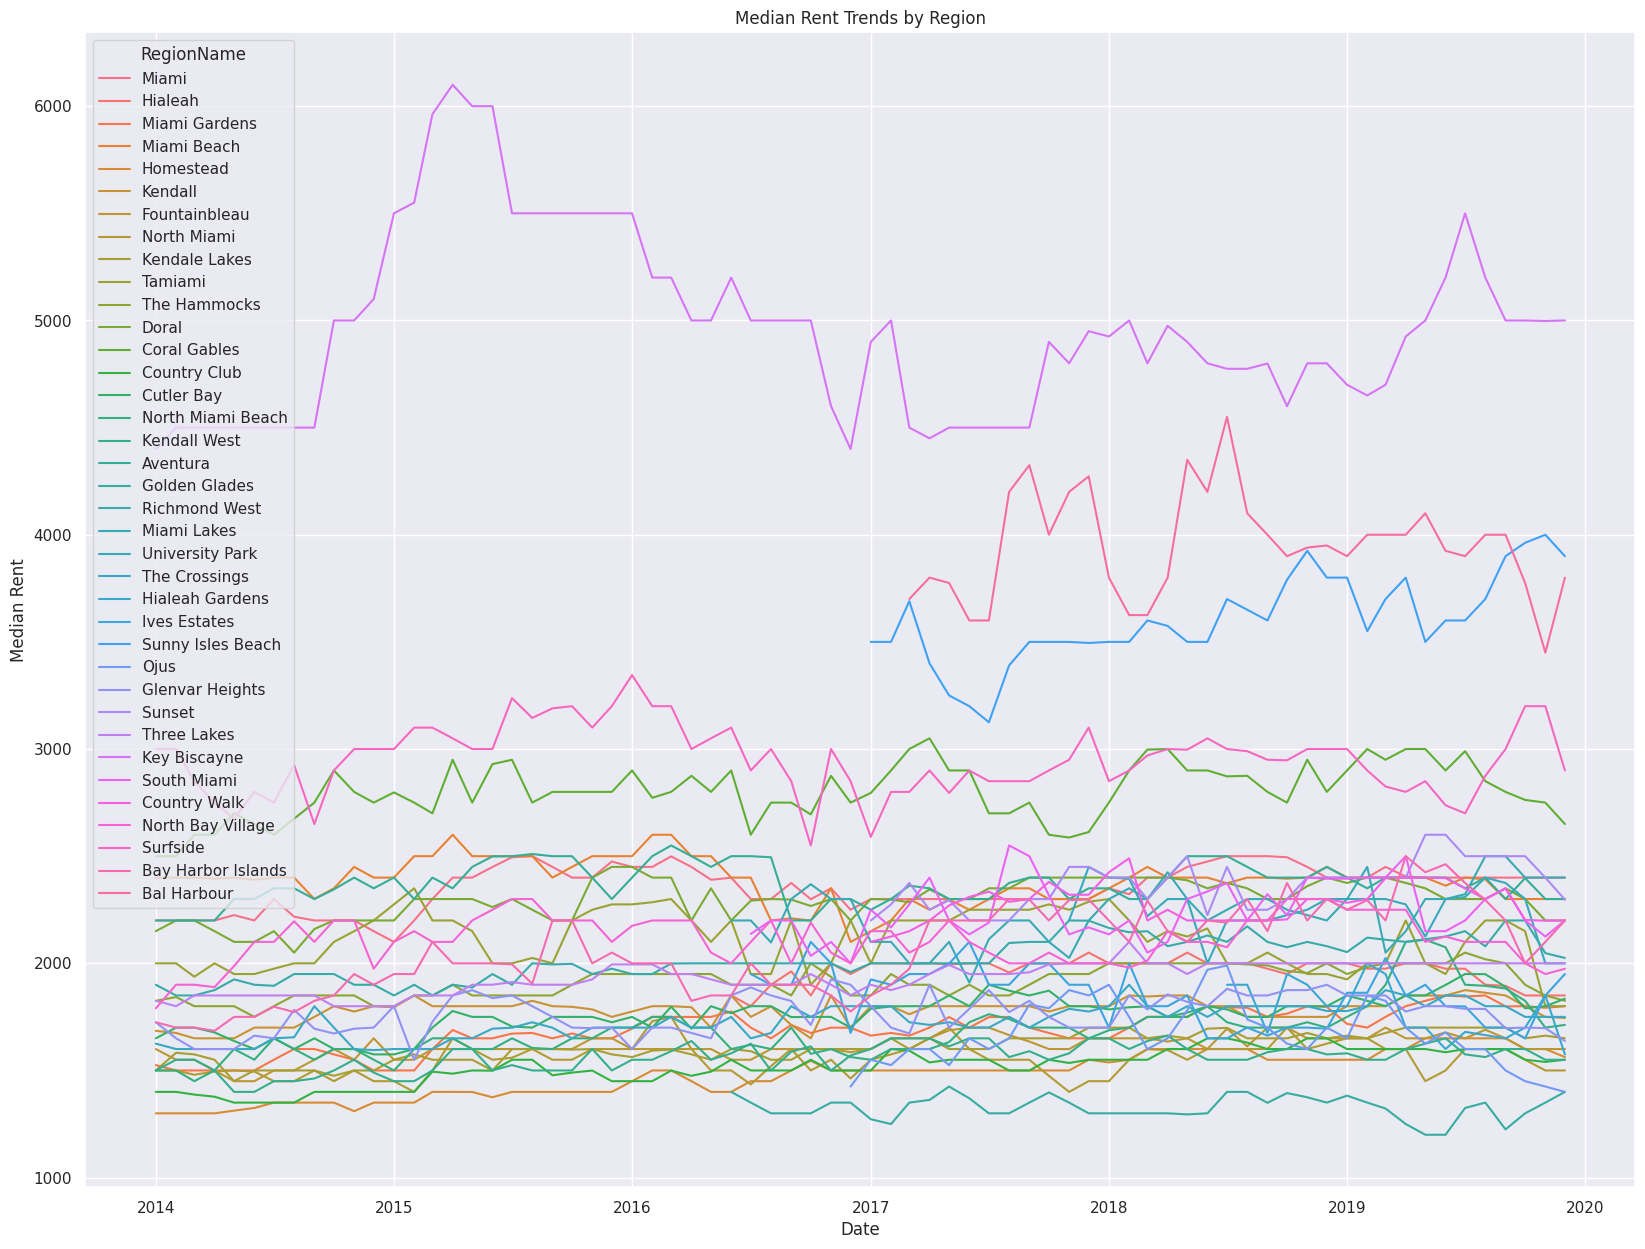

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Root Mean Squared Error (RMSE): 82.65877407494284
R^2 Score: 0.9869718646637077


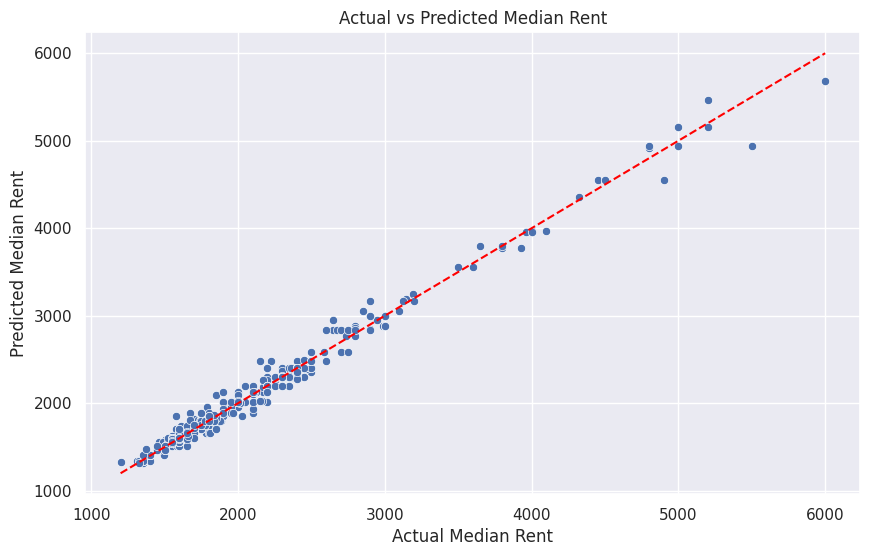

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Load and Filter the Dataset
homes_df = pd.read_csv('/content/City_MedianRentalPrice_AllHomes.csv')

# Filter for Miami-Dade County
homes_df = homes_df.query('CountyName == "Miami-Dade County"')

# Drop irrelevant columns
test_df = homes_df.drop(homes_df.iloc[:, 6:54], axis=1)  # Drop the date columns
test_df = test_df.drop('Unnamed: 0', axis=1).reset_index()
test_df = test_df.drop(['index', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1)

# Display the cleaned data
print(test_df.head())

# Step 2: Transform Data for Time Series Analysis
# Transpose the data
p_test = test_df.T
p_test = p_test.rename(columns=p_test.iloc[0])  # Rename columns based on 'RegionName'
p_test = p_test.drop(['RegionName'], axis=0)
p_test['date'] = p_test.index  # Create a date column from index

# Save to CSV (optional)
p_test.to_csv('MedianRentPrices.csv', index=False)

# Reshape the dataset for visualization and modeling
test_melt = test_df.melt('RegionName', var_name='date', value_name='median_rent')
test_melt['date'] = pd.to_datetime(test_melt['date'], yearfirst=True)

# Step 3: Analyze Trends
test_melt.info()

# Calculate percentage change for rent
percent_change = test_melt.groupby('RegionName')['median_rent'].value_counts(normalize=True)
percent_change = percent_change.mul(100).rename('Percent').reset_index()

# Plot trends
sns.set(rc={'figure.figsize': (20, 15)})
sns.lineplot(x=test_melt['date'], y=test_melt['median_rent'], hue=test_melt['RegionName'])
plt.title("Median Rent Trends by Region")
plt.xlabel("Date")
plt.ylabel("Median Rent")
plt.show()

# Step 4: Feature Engineering
# Create lag features (previous month's rent) to predict the next month's rent
test_melt = test_melt.sort_values(by=['RegionName', 'date'])
test_melt['prev_rent'] = test_melt.groupby('RegionName')['median_rent'].shift(1)

# Drop rows with NaN values created by lagging
test_melt = test_melt.dropna()

# Step 5: Prepare Data for Modeling
# Features and target
X = test_melt[['prev_rent']]
y = test_melt['median_rent']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Train a Machine Learning Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 7: Evaluate the Model
y_pred = model.predict(X_test) # Predict the median rent using the model

# Metrics
rmse = mean_squared_error(y_test, y_pred, squared=False) # Calculate the root mean squared error and the r^2 score in order to test how good the model explains the data.
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R^2 Score: {r2}")

# Step 8: Plot the predictions
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual Median Rent")
plt.ylabel("Predicted Median Rent")
plt.title("Actual vs Predicted Median Rent")
plt.show()
